<a href="https://colab.research.google.com/github/Walbyq/wb-orders-timeseries-forecast/blob/main/wb_orders_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка библиотек

In [ ]:
!pip install pmdarima

# Импорт бибилиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.tsa.api as smt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Загрузка набора данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
usecols=['date', 'total_price', 'nm_id', 'is_cancel']
df = pd.read_csv('/content/drive/MyDrive/data/wb_orders/wb_orders.csv', usecols=usecols)

<ipython-input-7-a3149dd2cb51>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/data/wb_orders/wb_orders.csv', usecols=usecols)


# Подготовка набора данных

In [ ]:
# Обрабатываем строки: удаляем пробелы и заменяем запятые на точки
df['total_price'] = df['total_price'].apply(
    lambda x: str(x).strip().replace(',', '.')
    if isinstance(x, str) else x
    )

# Преобразуем строки в числа, оставляя числовые значения нетронутыми
df['total_price'] = pd.to_numeric(df['total_price'], errors='coerce')

In [ ]:
df = df[df['is_cancel'] == False]
df = df.drop(columns=['is_cancel'])

# Обучение

Напишем функции для обучения и прогнозирования модели SARIMA:

In [ ]:
# Функция для визуализации временных рядов
def tsplot(y, id, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(f"Time Series Analysis Plots\n Dickey-Fuller: p={p_value:.5f}\nID={id}")
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        plt.show()

Предобработаем датафрейм:

In [ ]:
#  Преобразуйте столбец 'date' в datetime и установите его в качестве индекса
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df = df.set_index('date')

# Группируем по nm_id
grouped = df.groupby('nm_id')

Запустим модель обучения и получим результаты прогноза:

In [ ]:
def forecast_and_validation(grouped, aggregation='sum', num_periods=4, confidence_level=0.95, freq='W'):
    """
    Объединяет проверку модели на исторических данных и прогнозирование на будущее.

    Args:
        grouped (pd.DataFrameGroupBy): Сгруппированные данные по nm_id.
        y_column (str): Название столбца, который нужно прогнозировать.
        aggregation (str):  'sum' или 'mean' для агрегации данных.
        num_periods (int): Количество периодов для прогнозирования в будущем.
        confidence_level (float): Уровень доверия для интервалов (например, 0.95 для 95%).
        freq (str): Частота передискретизации данных (например, 'W' для недельной).
    """

    for nm_id, group in grouped:
        # Агрегируем данные
        if aggregation == 'sum':
            group_resampled = group['total_price'].resample(freq).sum()
        elif aggregation == 'mean':
            group_resampled = group['total_price'].resample(freq).mean()
        else:
            raise ValueError("Аргумент aggregation должен быть 'sum' или 'mean'")

        group_resampled = group_resampled.asfreq(freq).ffill()

        # Разделяем данные на обучающую и тестовую выборки
        split_index = int(len(group_resampled) * 0.8)
        train = group_resampled[:split_index]
        test = group_resampled[split_index:]

        # Автоматический подбор параметров ARIMA
        arima_model = auto_arima(train, seasonal=True,
                                stepwise=True, trace=False,
                                error_action='ignore', suppress_warnings=True)

        # Прогнозы на тестовой выборке (для проверки)
        test_predictions, test_conf_int = arima_model.predict(n_periods=len(test), return_conf_int=True, alpha=1-confidence_level)
        test_predictions_series = pd.Series(test_predictions, index=test.index)
        test_lower_series = pd.Series(test_conf_int[:, 0], index=test.index)
        test_upper_series = pd.Series(test_conf_int[:, 1], index=test.index)

        # Рассчет MAPE на тестовой выборке
        def calculate_mape(y_true, y_pred):
            y_true, y_pred = np.array(y_true), np.array(y_pred)
            # Добавляем небольшое значение, чтобы избежать деления на ноль
            return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

        mape = calculate_mape(test, test_predictions)

        # Прогнозы на будущий период (обучаем модель на всех доступных данных)
        arima_model_full = auto_arima(group_resampled, seasonal=True,
                                    stepwise=True, trace=False,
                                    error_action='ignore', suppress_warnings=True)
        future_predictions, future_conf_int = arima_model_full.predict(n_periods=num_periods, return_conf_int=True, alpha=1-confidence_level)

        # Создаем индекс для будущих дат
        last_date = group_resampled.index[-1]
        future_dates = pd.date_range(last_date + pd.Timedelta(weeks=1), periods=num_periods, freq=freq)
        future_predictions_series = pd.Series(future_predictions, index=future_dates)
        future_lower_series = pd.Series(future_conf_int[:, 0], index=future_dates)
        future_upper_series = pd.Series(future_conf_int[:, 1], index=future_dates)

        # Визуализация
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 2, 1)
        plt.plot(group_resampled, label='История')
        plt.plot(test_predictions_series, label=f'Прогноз (тест) MAPE={mape:.2f}%', color='orange')
        plt.fill_between(test_lower_series.index, test_lower_series, test_upper_series, color='orange', alpha=0.2)
        plt.xlabel('Дата')
        plt.ylabel('Значение')
        plt.title(f'Проверка модели на исторических данных\nID: {nm_id}')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(group_resampled, label='История', alpha=0.7)
        plt.plot(future_predictions_series, label='Прогноз (будущее)', color='green')
        plt.fill_between(future_lower_series.index, future_lower_series, future_upper_series, color='green', alpha=0.2)
        plt.xlabel('Дата')
        plt.ylabel('Значение')
        plt.title(f'Прогноз на {num_periods} периодов вперед\nID: {nm_id}')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Выводим прогнозы на будущее
        total_predicted_value = future_predictions_series.sum()
        print(f"Прогнозы на следующие {num_periods} периода для ID={nm_id}:")
        print(future_predictions_series)
        print(f"Общая прогнозируемая сумма: {total_predicted_value:.2f}")

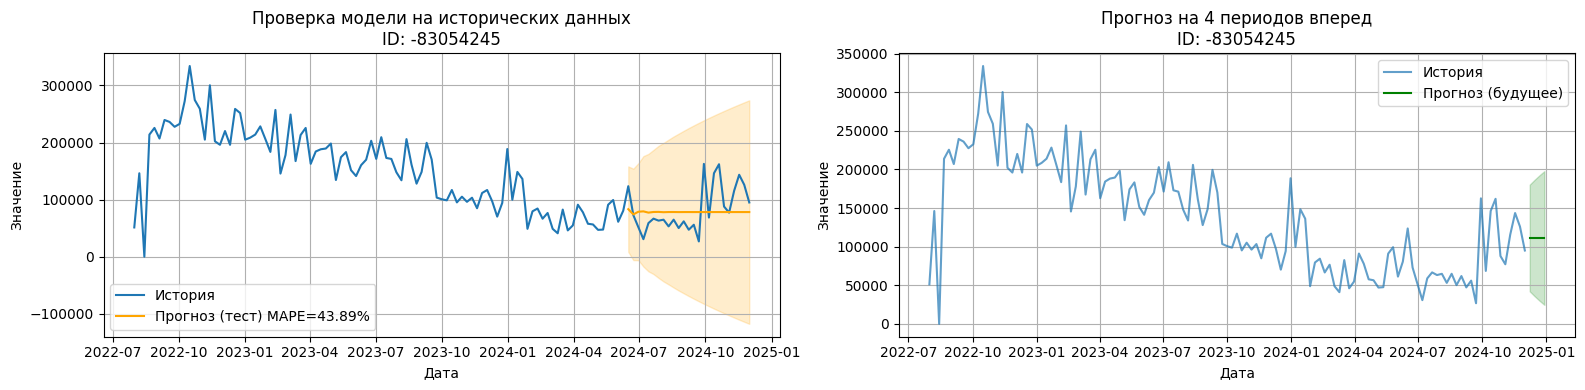

Прогнозы на следующие 4 периода для ID=-83054245:
2024-12-08    111227.62287
2024-12-15    111227.62287
2024-12-22    111227.62287
2024-12-29    111227.62287
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 444910.49


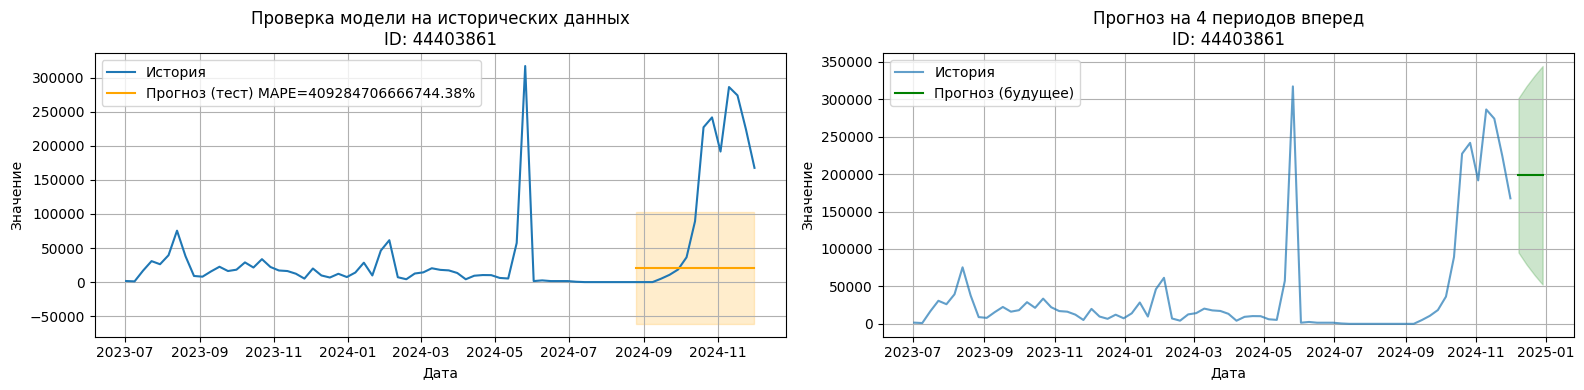

Прогнозы на следующие 4 периода для ID=44403861:
2024-12-08    198336.173883
2024-12-15    198336.173883
2024-12-22    198336.173883
2024-12-29    198336.173883
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 793344.70


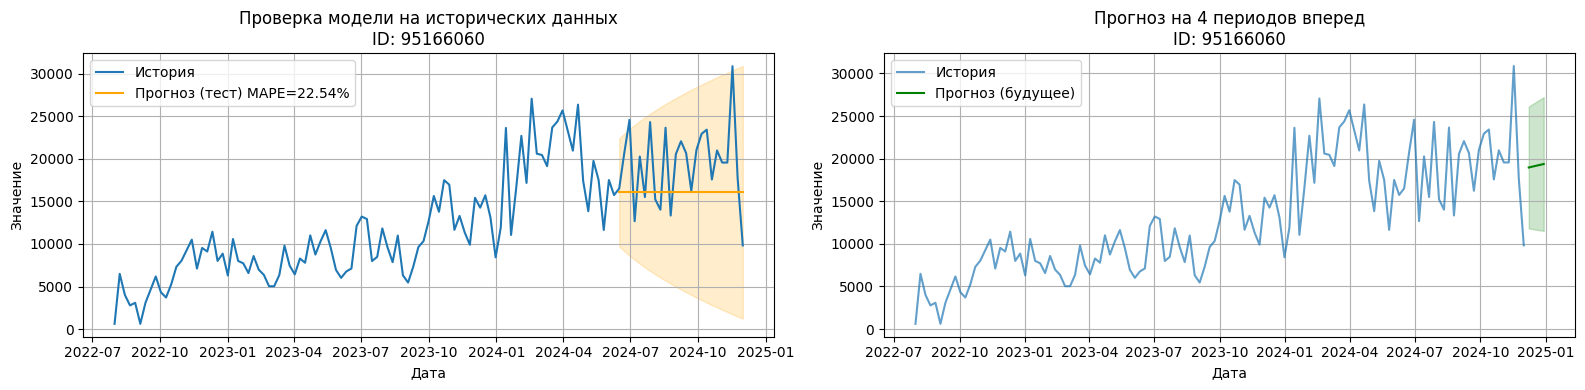

Прогнозы на следующие 4 периода для ID=95166060:
2024-12-08    18969.210408
2024-12-15    19104.635235
2024-12-22    19240.060061
2024-12-29    19375.484887
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 76689.39


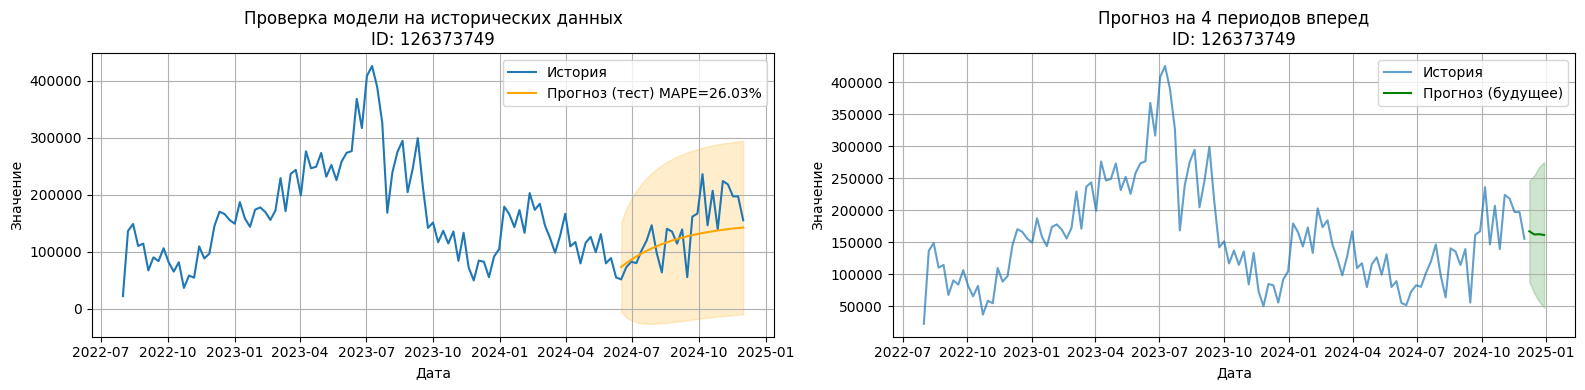

Прогнозы на следующие 4 периода для ID=126373749:
2024-12-08    167140.636308
2024-12-15    162171.973982
2024-12-22    162583.523787
2024-12-29    161408.261736
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 653304.40


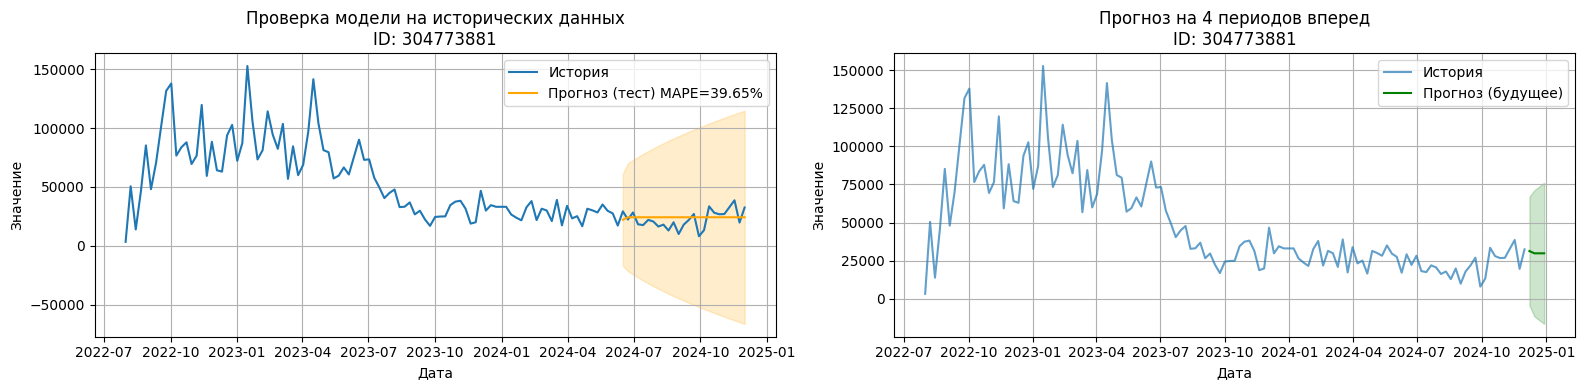

Прогнозы на следующие 4 периода для ID=304773881:
2024-12-08    31367.131620
2024-12-15    29876.773875
2024-12-22    29876.773875
2024-12-29    29876.773875
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 120997.45


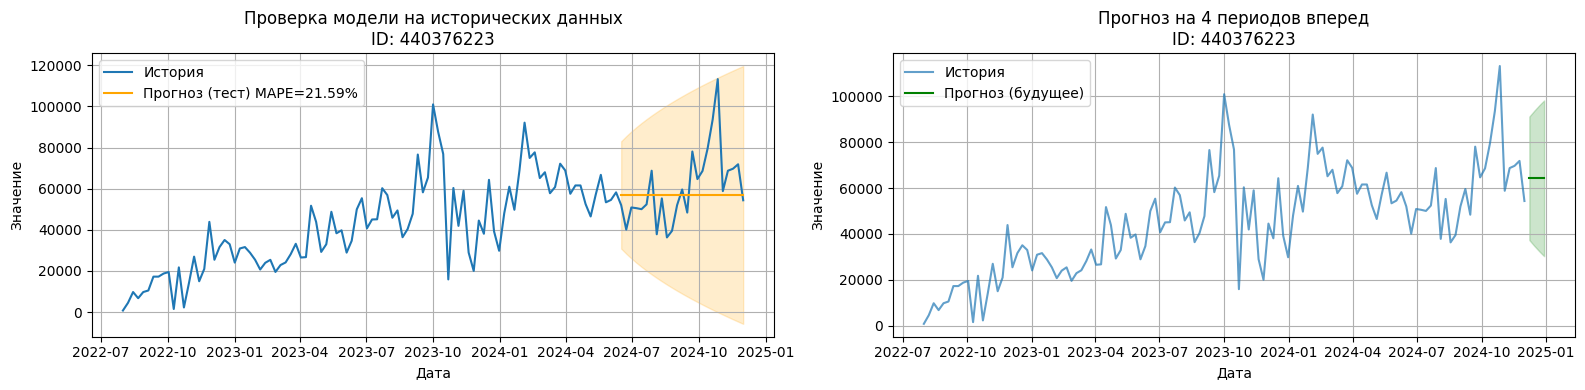

Прогнозы на следующие 4 периода для ID=440376223:
2024-12-08    64257.570021
2024-12-15    64257.570021
2024-12-22    64257.570021
2024-12-29    64257.570021
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 257030.28


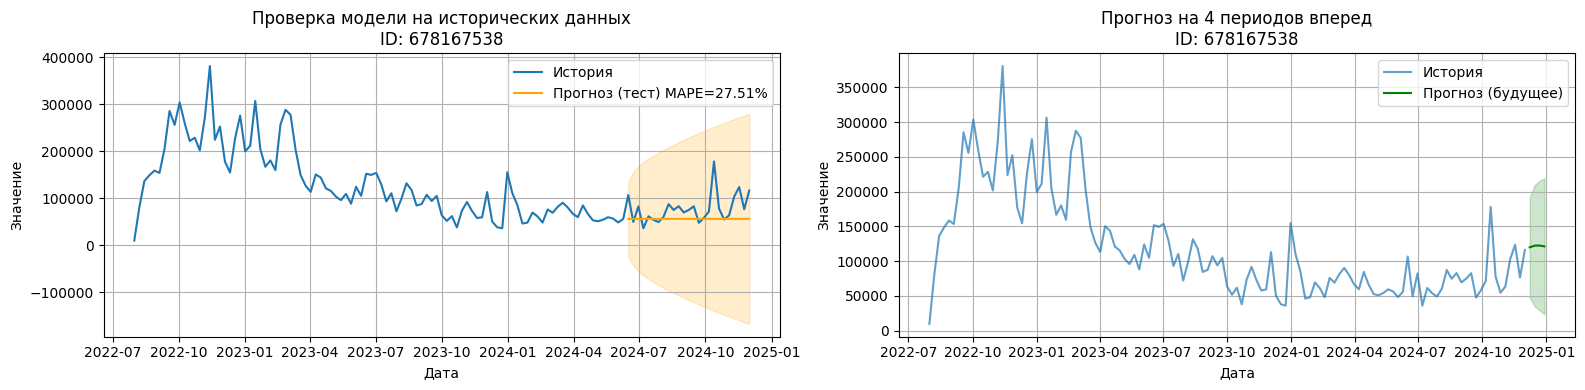

Прогнозы на следующие 4 периода для ID=678167538:
2024-12-08    119817.051670
2024-12-15    122139.185495
2024-12-22    122438.931953
2024-12-29    121135.044416
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 485530.21


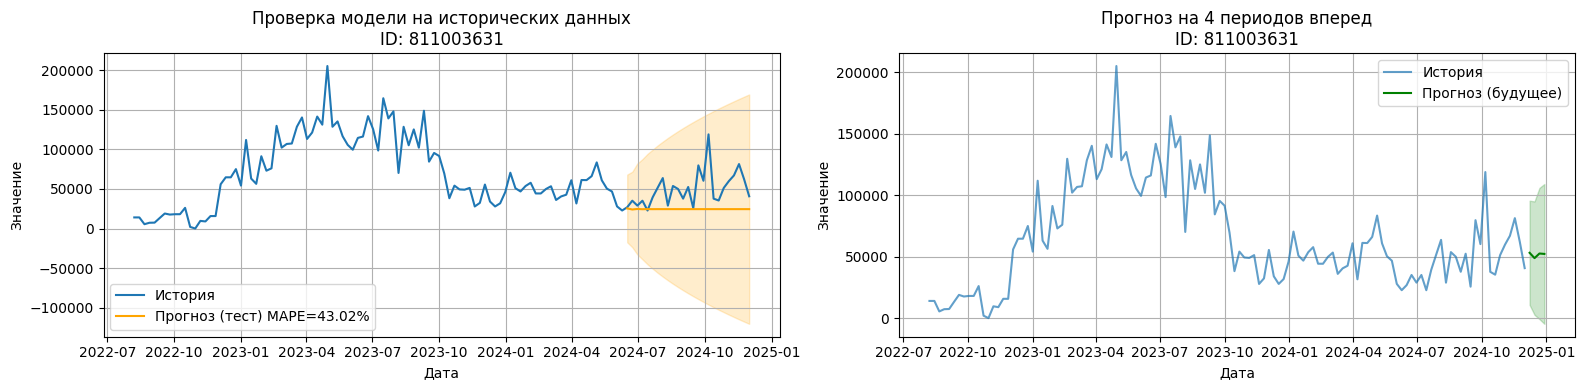

Прогнозы на следующие 4 периода для ID=811003631:
2024-12-08    53193.946592
2024-12-15    48870.403001
2024-12-22    52625.110473
2024-12-29    52293.215602
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 206982.68


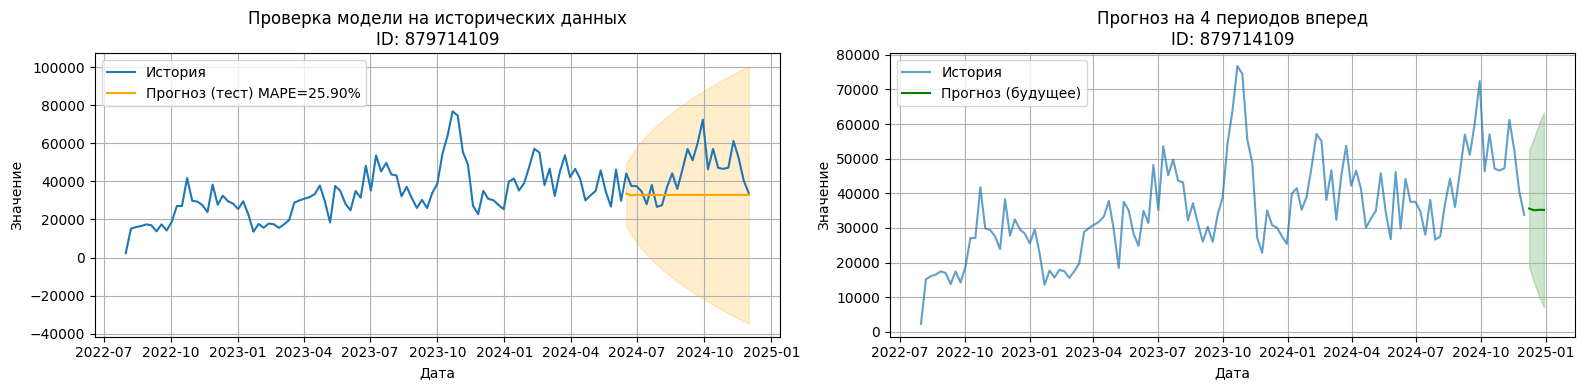

Прогнозы на следующие 4 периода для ID=879714109:
2024-12-08    35611.295634
2024-12-15    35095.116066
2024-12-22    35237.804423
2024-12-29    35198.360849
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 141142.58


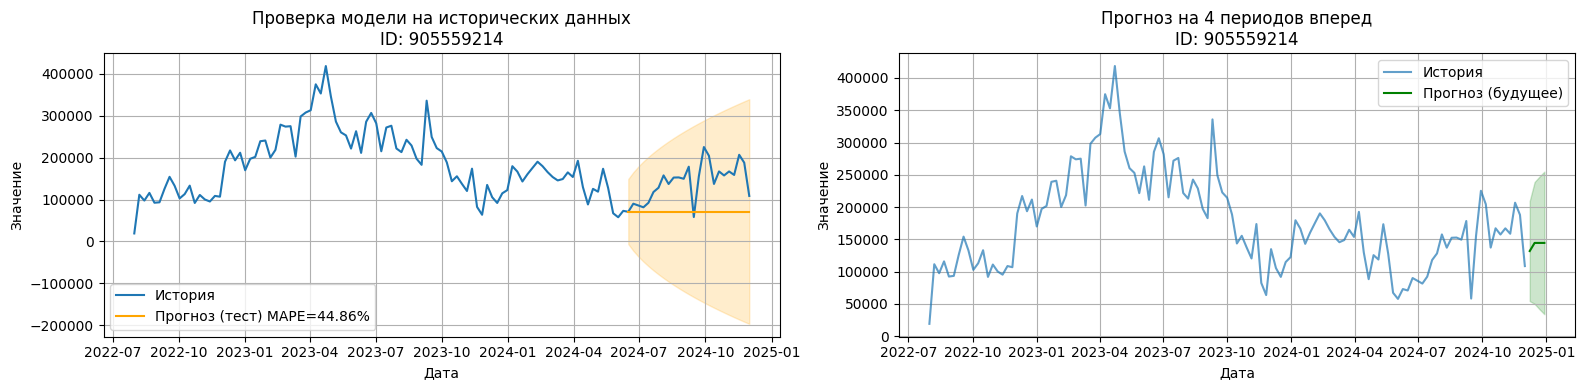

Прогнозы на следующие 4 периода для ID=905559214:
2024-12-08    131905.171034
2024-12-15    144471.152073
2024-12-22    144471.152073
2024-12-29    144471.152073
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 565318.63


In [ ]:
# Прогноз суммы продаж
forecast_and_validation(grouped, aggregation='sum', num_periods=4, confidence_level=0.95)

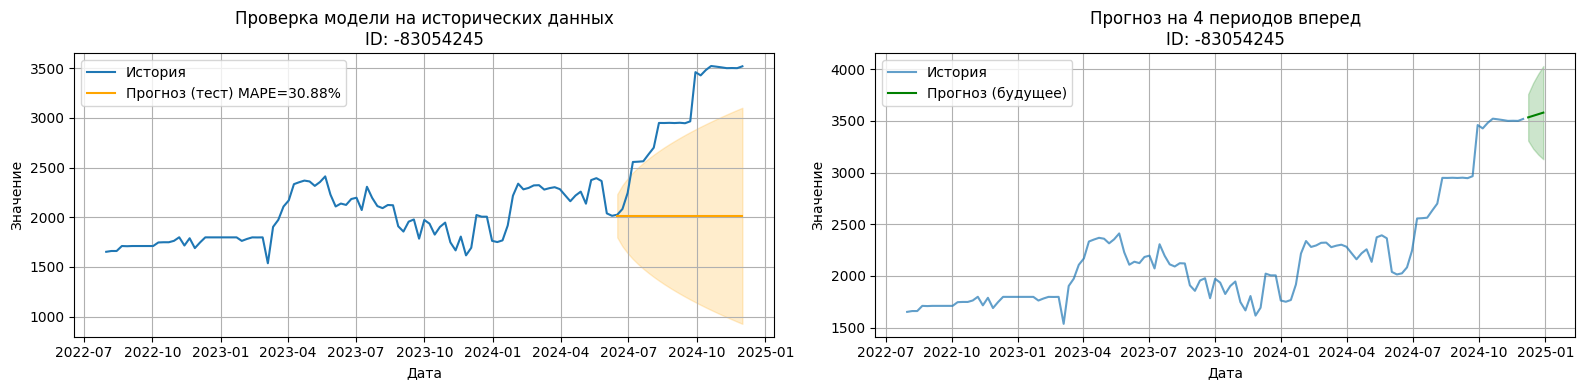

Прогнозы на следующие 4 периода для ID=-83054245:
2024-12-08    3533.996661
2024-12-15    3549.289618
2024-12-22    3564.582576
2024-12-29    3579.875533
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 14227.74


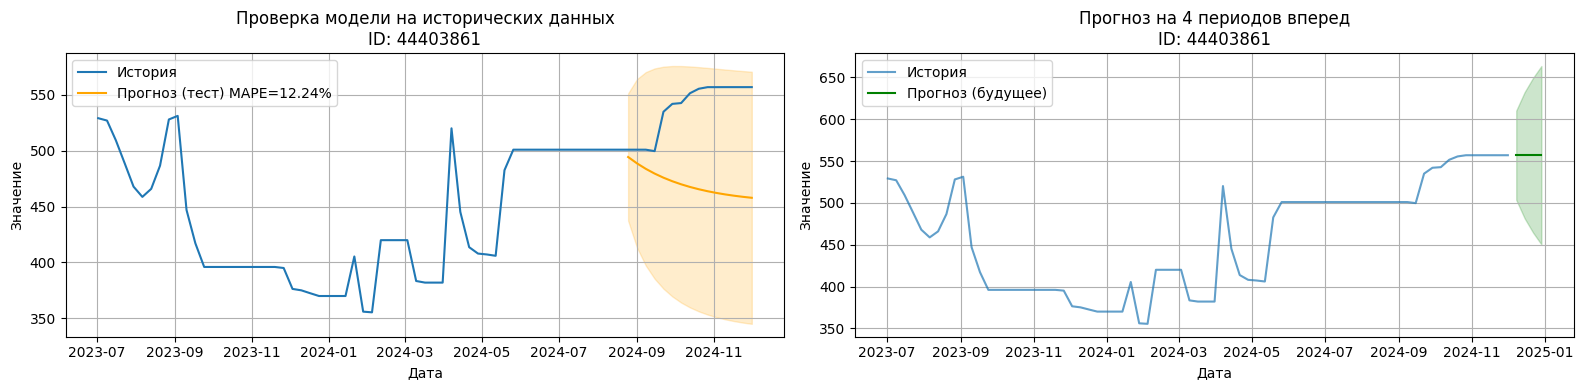

Прогнозы на следующие 4 периода для ID=44403861:
2024-12-08    557.0
2024-12-15    557.0
2024-12-22    557.0
2024-12-29    557.0
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 2228.00


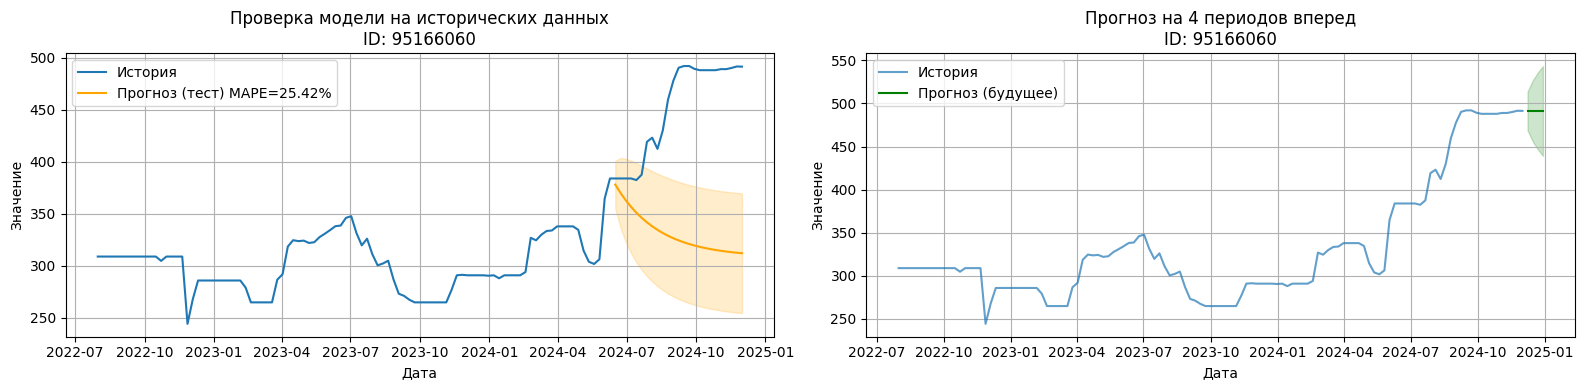

Прогнозы на следующие 4 периода для ID=95166060:
2024-12-08    491.317058
2024-12-15    491.317058
2024-12-22    491.317058
2024-12-29    491.317058
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 1965.27


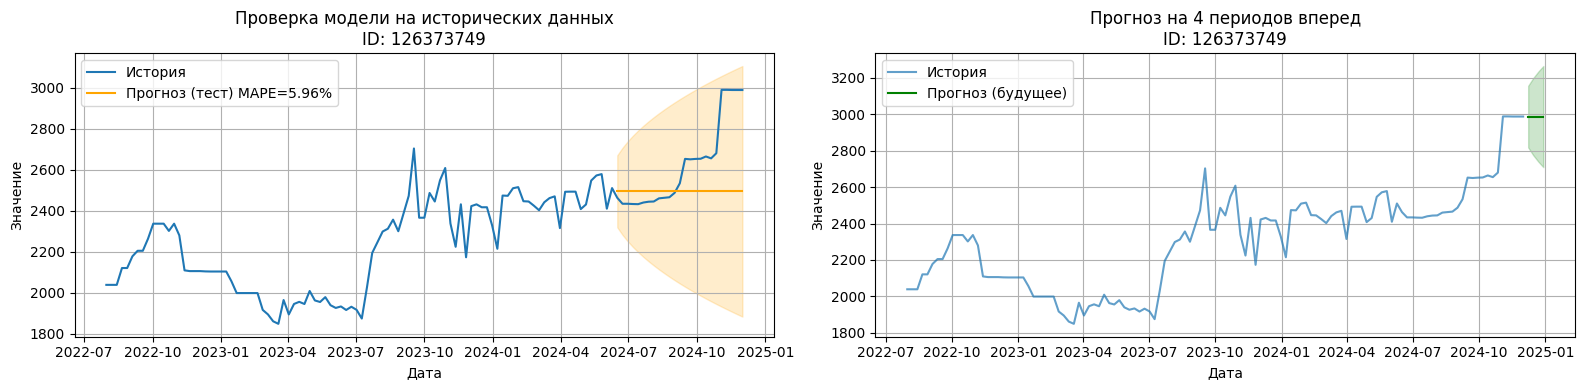

Прогнозы на следующие 4 периода для ID=126373749:
2024-12-08    2987.73142
2024-12-15    2987.73142
2024-12-22    2987.73142
2024-12-29    2987.73142
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 11950.93


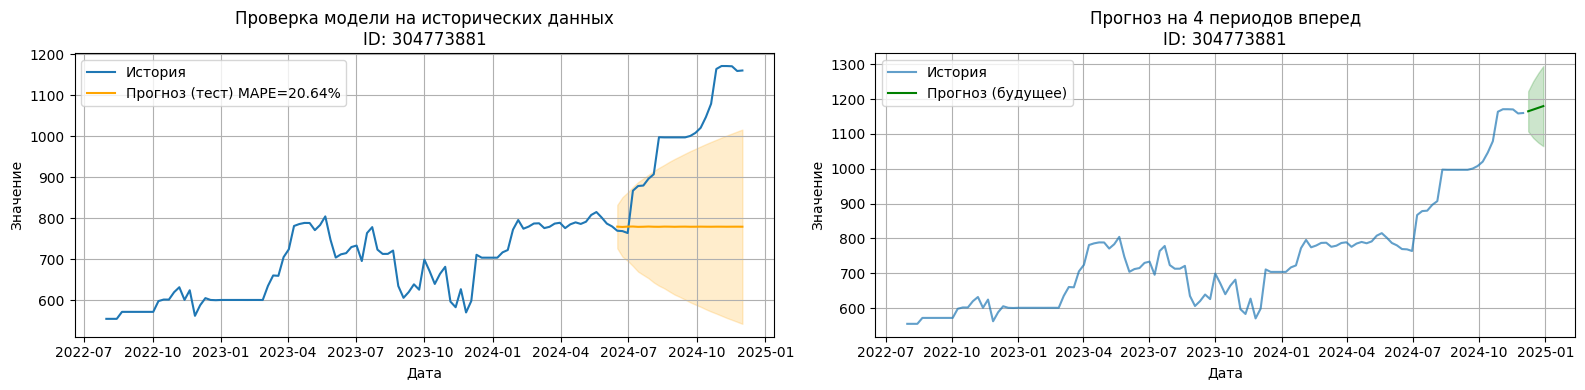

Прогнозы на следующие 4 периода для ID=304773881:
2024-12-08    1164.887002
2024-12-15    1169.845433
2024-12-22    1174.803864
2024-12-29    1179.762295
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 4689.30


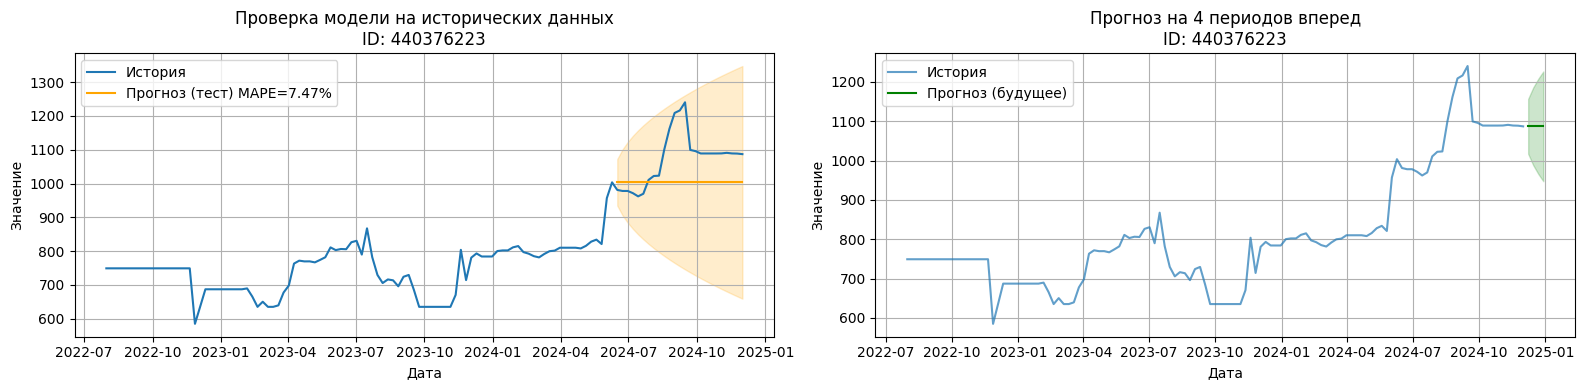

Прогнозы на следующие 4 периода для ID=440376223:
2024-12-08    1087.0
2024-12-15    1087.0
2024-12-22    1087.0
2024-12-29    1087.0
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 4348.00


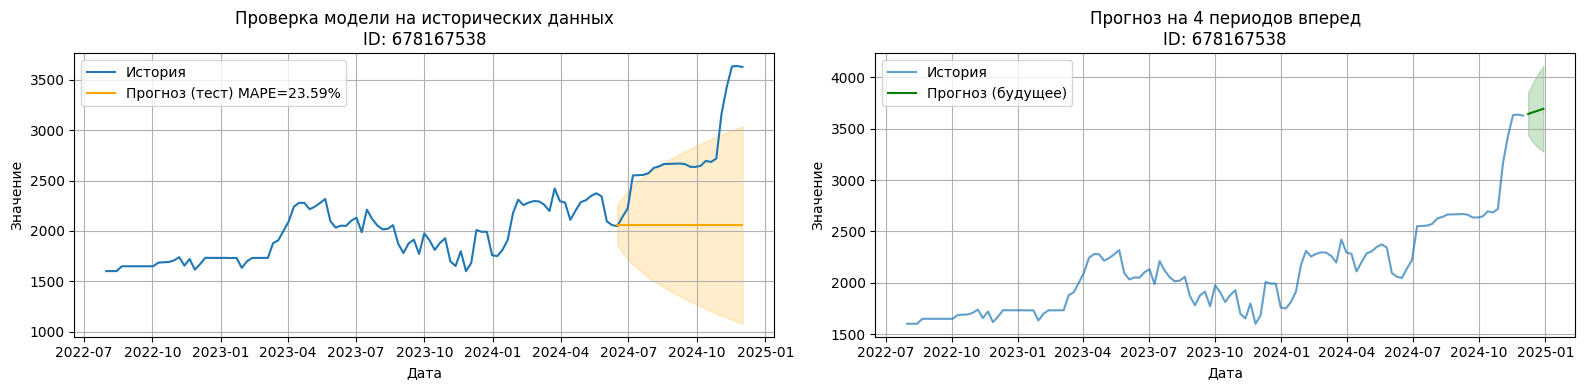

Прогнозы на следующие 4 периода для ID=678167538:
2024-12-08    3644.007941
2024-12-15    3660.609631
2024-12-22    3677.211322
2024-12-29    3693.813012
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 14675.64


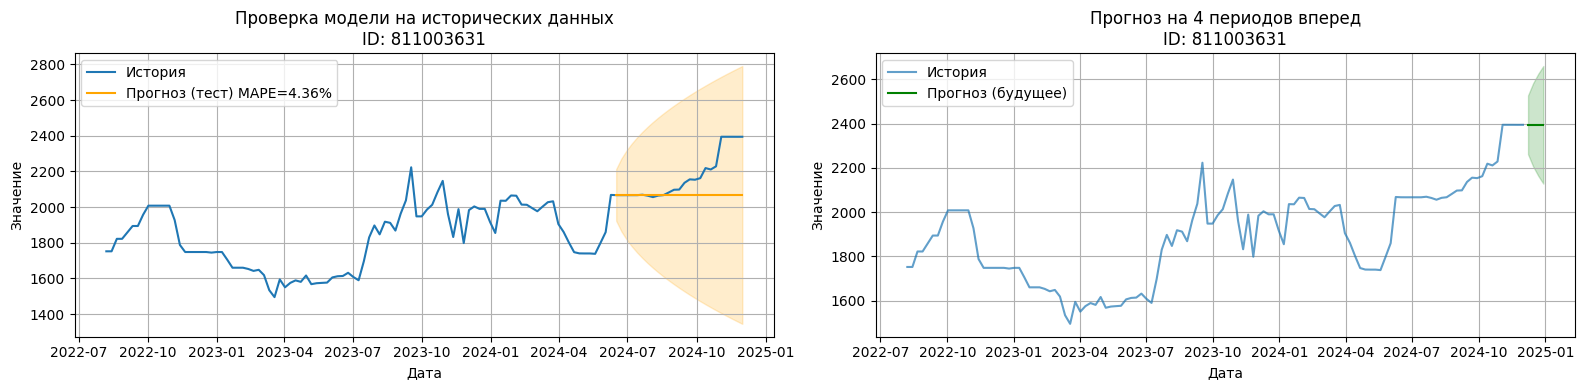

Прогнозы на следующие 4 периода для ID=811003631:
2024-12-08    2394.529412
2024-12-15    2394.529412
2024-12-22    2394.529412
2024-12-29    2394.529412
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 9578.12


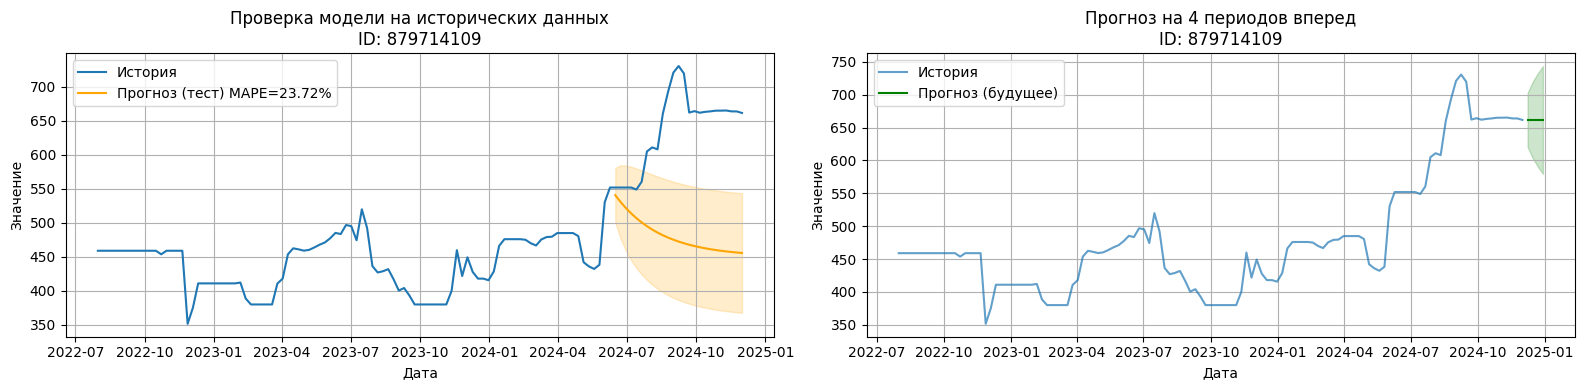

Прогнозы на следующие 4 периода для ID=879714109:
2024-12-08    661.647059
2024-12-15    661.647059
2024-12-22    661.647059
2024-12-29    661.647059
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 2646.59


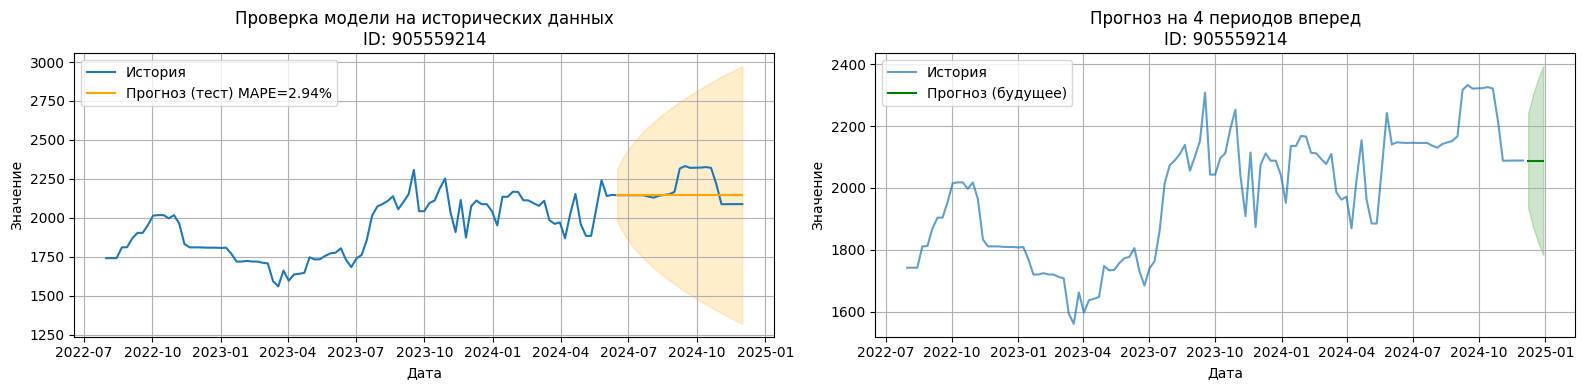

Прогнозы на следующие 4 периода для ID=905559214:
2024-12-08    2088.5
2024-12-15    2088.5
2024-12-22    2088.5
2024-12-29    2088.5
Freq: W-SUN, dtype: float64
Общая прогнозируемая сумма: 8354.00


In [ ]:
# Прогноз среднего значения продаж
forecast_and_validation(grouped, aggregation='mean', num_periods=4, confidence_level=0.95)